In [1]:
import os
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt

import torch
from torch import nn

from torch.utils.data import DataLoader

from utils import transforms
from utils import metrics
from utils import display
from utils.data import BabbledLibri
from utils.data import load_libri
from utils.utils import set_device, set_seed
from models import FCAE, CDAE, UNet
import train


seed = 1
set_seed(seed)
device = set_device()

Device:  cpu


In [2]:
batch_size = 2
pin_memory = (device == 'cuda')

libri_path = 'data/libri-dev-clean'
srate = 16000
train_mins, val_mins, test_mins = 1, 1, 1


# Set size variables
train_idx = int(srate*60*train_mins)
val_idx = int(srate*60*val_mins)
test_idx = int(srate*60*test_mins)
max_minutes = train_mins + val_mins + test_mins
max_samples = int(srate*60*max_minutes)

# Load speech data
speech = load_libri(libri_path, srate, max_samples)

train_data = BabbledLibri(
    speech[:train_idx],
    srate=srate,
    babble_path='data/babble.wav',
    babble_gains=[0.2],
    n_fft=512, hop_len=256,
    conv=False,
    verbose=True)
                                         
train_dl = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=pin_memory)

val_data = BabbledLibri(
    speech[train_idx:(train_idx + val_idx)],
    srate=srate,
    babble_path='data/babble.wav',
    babble_gains=[0.2],
    n_fft=512, hop_len=256,
    conv=False,
    verbose=True)
                                         
val_dl = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=pin_memory)

test_data = BabbledLibri(
    speech[(train_idx + val_idx):(train_idx + val_idx + test_idx)],
    srate=srate,
    babble_path='data/babble.wav',
    babble_gains=[0.2],
    n_fft=512, hop_len=256,
    conv=False,
    verbose=True)
                                         
test_dl = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=pin_memory)

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/30 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/30 [00:00<?, ?it/s]

Original Signal


Denoised Signal


{'rmse': 6.1822276, 'gain': -14.515806615795695}


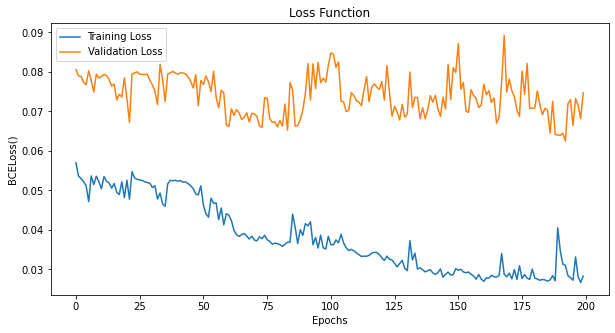

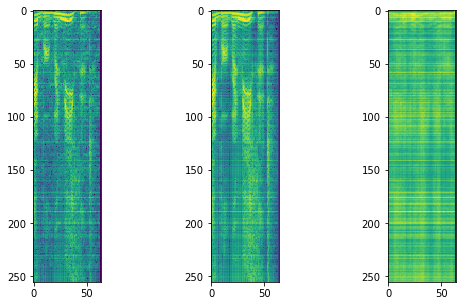

In [3]:
model = FCAE(
    in_shape=(256, 64),
    encoder_dims=[512, 256],
    decoder_dims=[256, 512],
    z_dim=128,
    out_activation='sigmoid',
    dropout=0.1)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)


model, history = train.train(
    device, model, 'fcae',
    train_dl, val_dl, output_dir='results',
    epochs=200, learning_rate=1e-3, criterion=nn.MSELoss())


# Plot Losses
fig, ax = plt.subplots(figsize=(10, 5))
ax = display.plot_losses(ax, history, repr(criterion))

# Evaluate model
metrics = train.evaluate(device, model, train_data, train_dl, fig=True, audio=True)
print(metrics)